In [95]:
%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [63]:
def create_data_frame(default_image_path:str, data_path:str, level_path:str, source_path:str):
    data = {}
    data['latex'] = []
    data['seq_len'] = []
    data['aspect_ratio'] = []
    data['image_width'] = []
    data['image_height'] = []
    data['level'] = []
    data['source'] = []
    data['path'] = []
    data['gt'] = []
    data['index'] = []
    all_latex_list = []
    lv1_latex_list = []
    lv2_latex_list = []
    lv3_latex_list = []
    lv4_latex_list = []
    lv5_latex_list = []
    
    with open(level_path) as f:
        level_info = {}
        for line in f:
            path, level = line.replace("\n","").split("\t")
            level_info[path] = int(level)
            
    with open(source_path) as f:
        source_info = {}
        for line in f:
            path, source = line.replace("\n","").split("\t")
            source_info[path] = str(source)
            
    with open(data_path) as f:
        for idx, line in enumerate(f):
            image_path, latex = line.replace("\n","").split("\t")
            image = Image.open(default_image_path + image_path)
            width, height = image.size
            data['path'].append(image_path)
            data['gt'].append(latex)
            data['index'].append(idx)
            data['aspect_ratio'].append(round(width / height, 1))
            data['image_width'].append(int(width))
            data['image_height'].append(int(height))
            latex = latex.split(" ")
            data['latex'].append(latex)
            data['seq_len'].append(len(latex))
            level = level_info[image_path]
            data['level'].append(level)
            source = source_info[image_path]
            data['source'].append(source)
            all_latex_list += latex
            if level == 1:
                lv1_latex_list += latex
            elif level == 2:
                lv2_latex_list += latex
            elif level == 3:
                lv3_latex_list += latex
            elif level == 4:
                lv4_latex_list += latex
            else:
                lv5_latex_list += latex
        df = pd.DataFrame.from_dict(data)
        lv_latex_list = [lv1_latex_list, lv2_latex_list, lv3_latex_list, lv4_latex_list, lv5_latex_list]
        return df, all_latex_list, lv_latex_list

In [64]:
df, all_latex_list, lv_latex_list = create_data_frame(default_image_path = "../input/data/train_dataset/images/", data_path="../input/data/train_dataset/gt.txt", level_path = "../input/data/train_dataset/level.txt", source_path = "../input/data/train_dataset/source.txt")

In [66]:
df.describe()

seq_len   aspect_ratio    image_width   image_height  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       17.536930       4.344388    1309.317910     333.098100   
std        14.952702       2.484526    1120.911322     312.306097   
min         1.000000       0.100000      35.000000      20.000000   
25%         7.000000       2.600000     563.000000     173.000000   
50%        13.000000       3.800000    1012.000000     255.000000   
75%        23.000000       5.500000    1732.000000     393.000000   
max       252.000000      33.900000   11810.000000   10020.000000   

               level          index  
count  100000.000000  100000.000000  
mean        2.392250   49999.500000  
std         0.845575   28867.657797  
min         1.000000       0.000000  
25%         2.000000   24999.750000  
50%         2.000000   49999.500000  
75%         3.000000   74999.250000  
max         5.000000   99999.000000

#### EDA 전에 고민해봐야할 점 
- 어떤 데이터 분포에 따라서 train/valid 데이터 나누는게 적절할까?
- 학습에 영향을 미칠 수 있는 불균형한 데이터 분포가 어떤 것이 있을까?
- 완전 손실된 정보 이외에 우리가 고쳐줄 수 있는 잘못된 데이터 있을까?

In [68]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes = True)
    fig, ax = plt.subplots(figsize = (18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


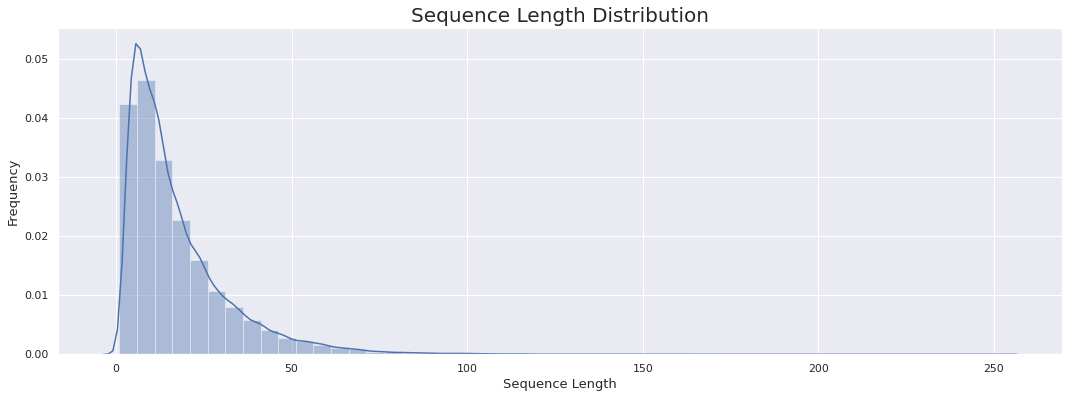

In [69]:
plot_dist(df=df, field='seq_len', bins=50, color='b', xlabel='Sequence Length', ylabel='Frequency', title='Sequence Length Distribution')

### Sequence Length에 따른 image visualization

In [144]:
def show_image(df, width, height):
    w = 10
    h = 10
    fig = plt.figure(figsize=(width, height))
    columns = 3
    rows = 3

    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns*rows):
        img = Image.open(default_image_path + df['path'].iloc[i])
        img = np.array(img)
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i+1) )
        plt.imshow(img)

    plt.show()  # finally, render the plot

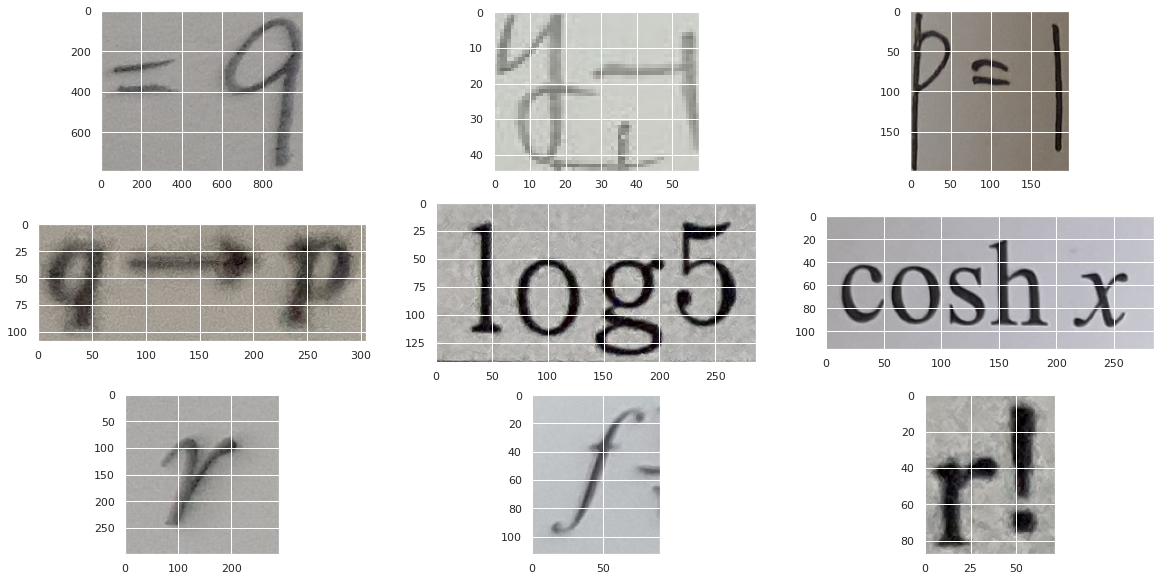

In [153]:
D = df[df['seq_len'] <= 2]
show_image(D, 20, 10)

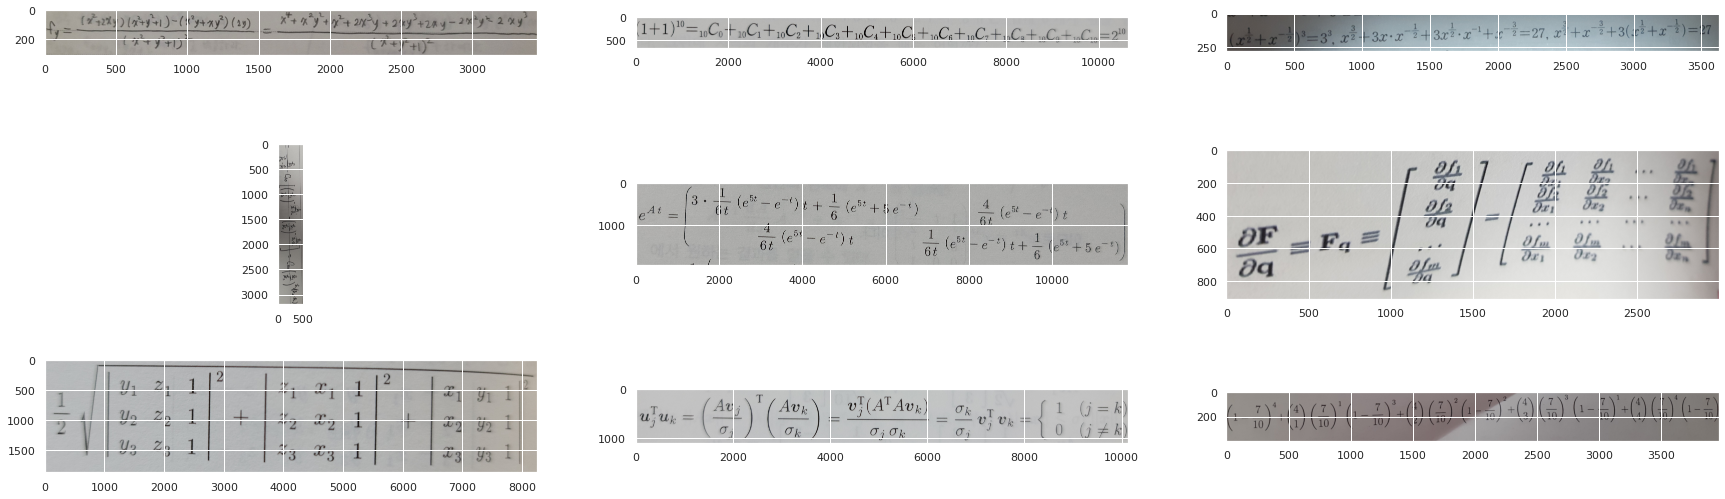

In [211]:
D = df[df['seq_len'] >= 150]
show_image(D, 30, 10)

- Sequence 길이가 긴 데이터 수가 적고, 데이터가 불 명확한 경우가 많아서 긴 데이터를 학습하는데 어려움 있을 것이라고 생각
- 이를 보완하기 위해서 짧은 데이터를 붙여서 데이터 증강하는 방법은 어떨까? (mix up하는 것 처럼)
- 긴 데이터를 자르는 경우는 데이터와 G.T의 잘리는 부분 맞춰야하는데 이는 역설적이라 생각

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


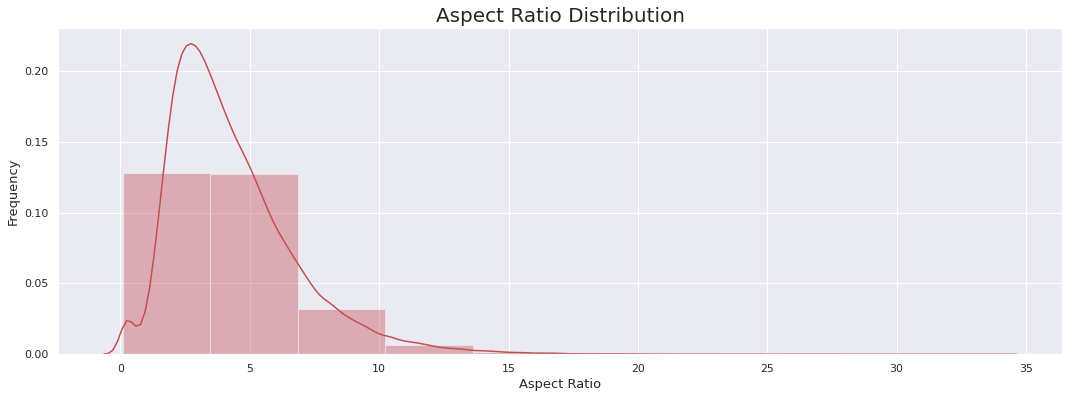

In [25]:
plot_dist(df=df, field='aspect_ratio', bins=10, color='r', xlabel = 'Aspect Ratio', ylabel = 'Frequency', title='Aspect Ratio Distribution')

### Aspect Ratio에 따른 image visualization

285


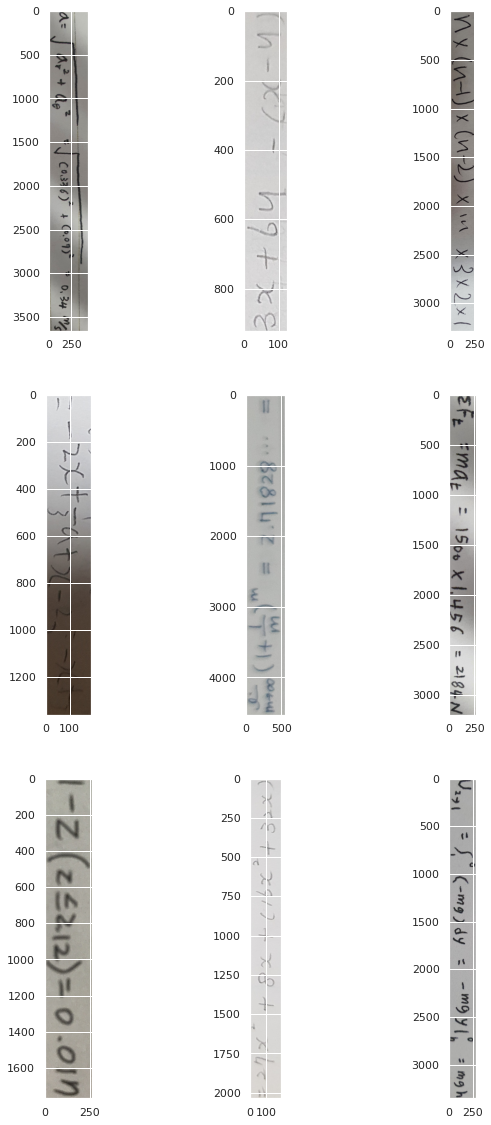

In [176]:
D = df[(df['aspect_ratio'] >0) & (df['aspect_ratio'] < 0.2)]
print(len(D))
show_image(D, 10, 20)

381


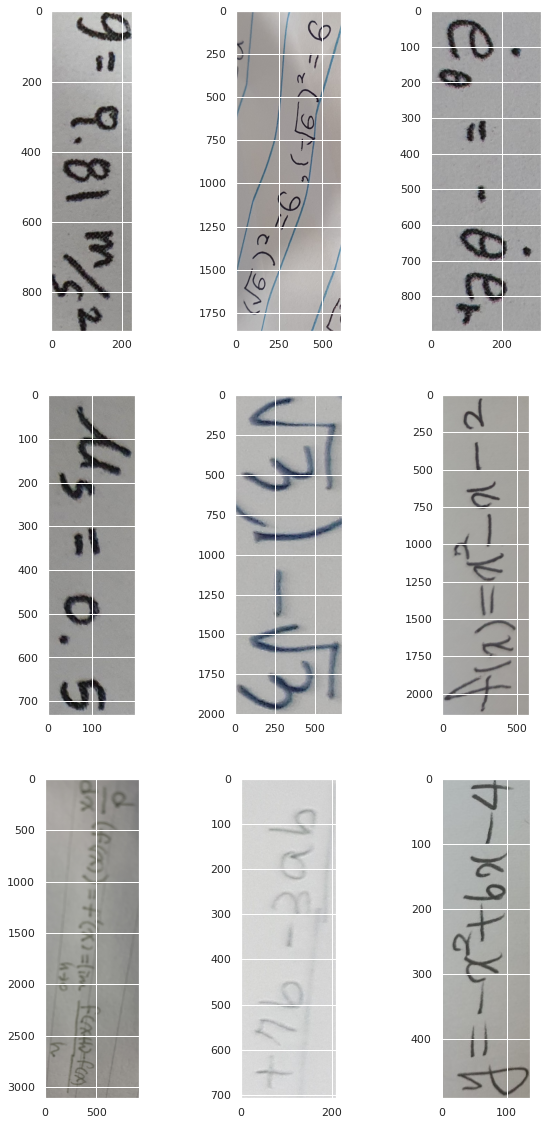

In [177]:
D = df[(df['aspect_ratio'] > 0.2) & (df['aspect_ratio'] < 0.4)]
print(len(D))
show_image(D, 10, 20)

132


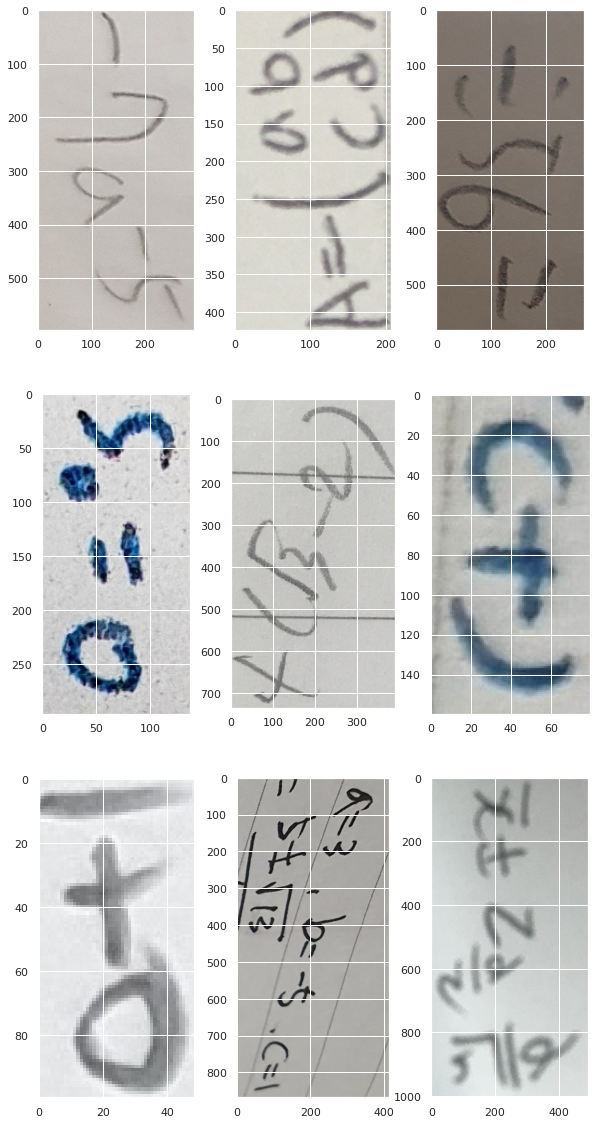

In [178]:
D = df[(df['aspect_ratio'] > 0.4) & (df['aspect_ratio'] < 0.6)]
print(len(D))
show_image(D, 10, 20)

134


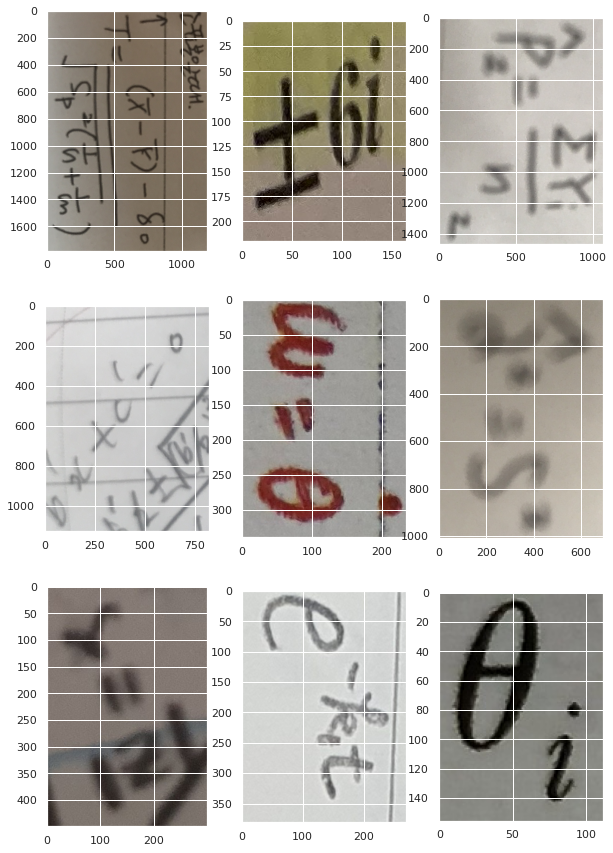

In [179]:
D = df[(df['aspect_ratio'] > 0.6) & (df['aspect_ratio'] < 0.8)]
print(len(D))
show_image(D, 10, 15)

161


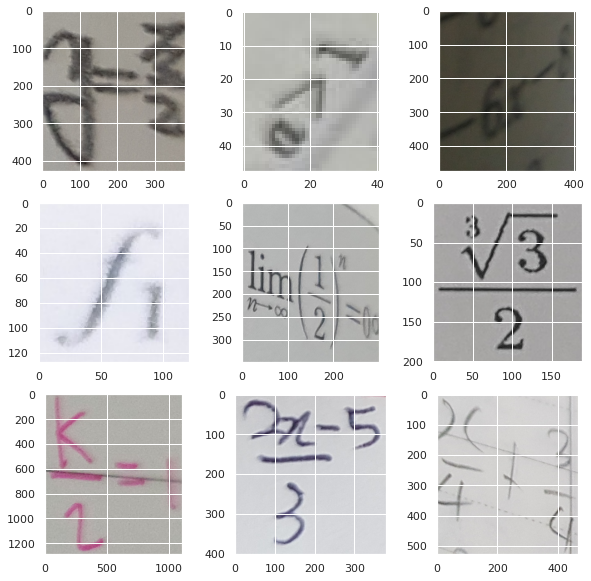

In [180]:
D = df[(df['aspect_ratio'] > 0.8) & (df['aspect_ratio'] < 1)]
print(len(D))
show_image(D, 10, 10)

327


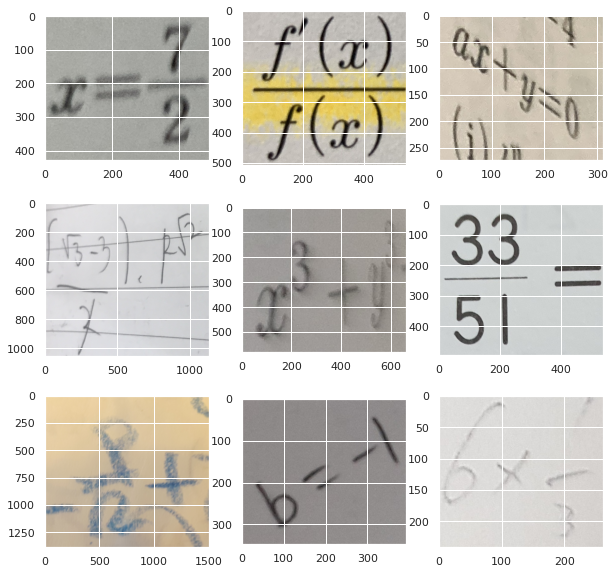

In [207]:
D = df[(df['aspect_ratio'] > 1) & (df['aspect_ratio'] < 1.2)]
print(len(D))
show_image(D, 10, 10)

44


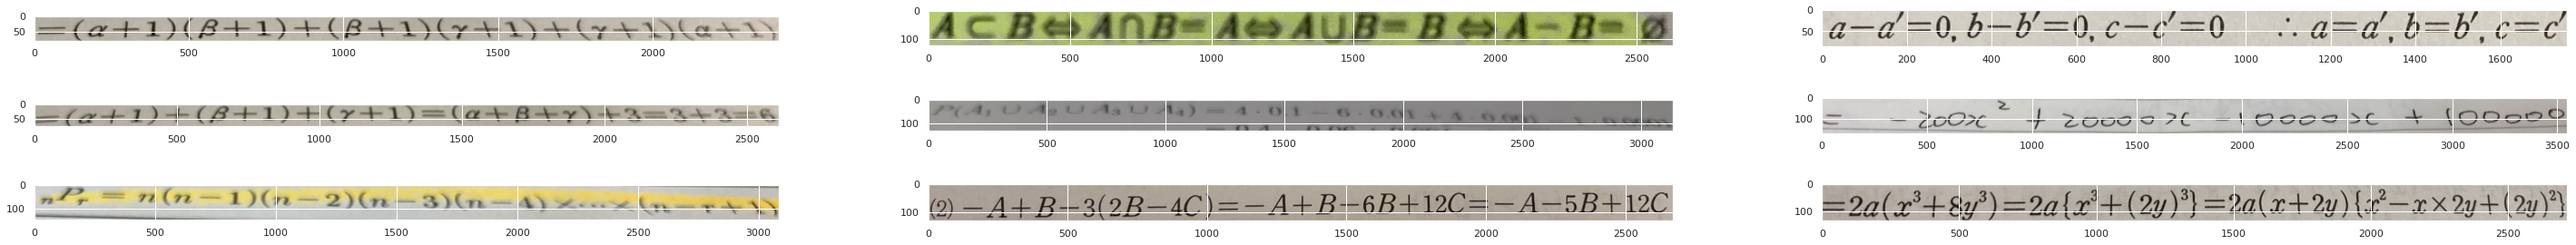

In [182]:
D = df[(df['aspect_ratio'] > 20)]
print(len(D))
show_image(D, 50, 5)

- aspect ratio가 작은 데이터에 대해서는 수식 이미지가 세로로 rotate된 경우를 많이 볼 수 있다. 
- 이를 돌려주는게 맞지 않은까? (일정 threshold 이하의 데이터들에 대해서) 
- 단, 시계방향, 반시계방향 rotate데이터 모두 존재 

### Level과 Source에 따른 image visualization

#### Level 1

3748


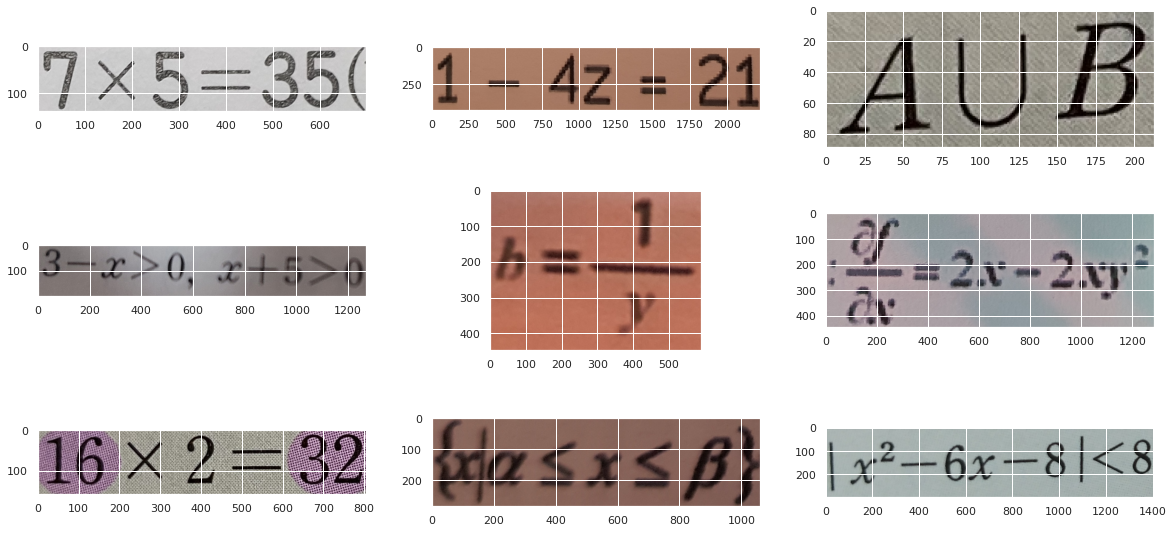

In [191]:
D = df[(df['level'] == 1) & (df['source'] == '0')]
print(len(D))
show_image(D, 20, 10)

9753


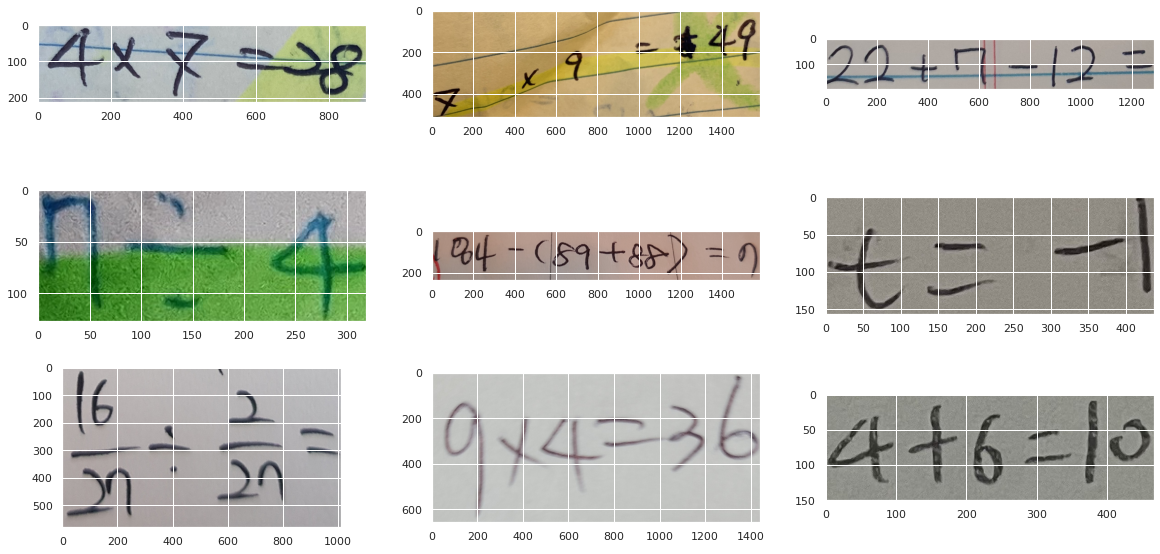

In [192]:
D = df[(df['level'] == 1) & (df['source'] == '1')]
print(len(D))
show_image(D, 20, 10)

#### Level 2

32288


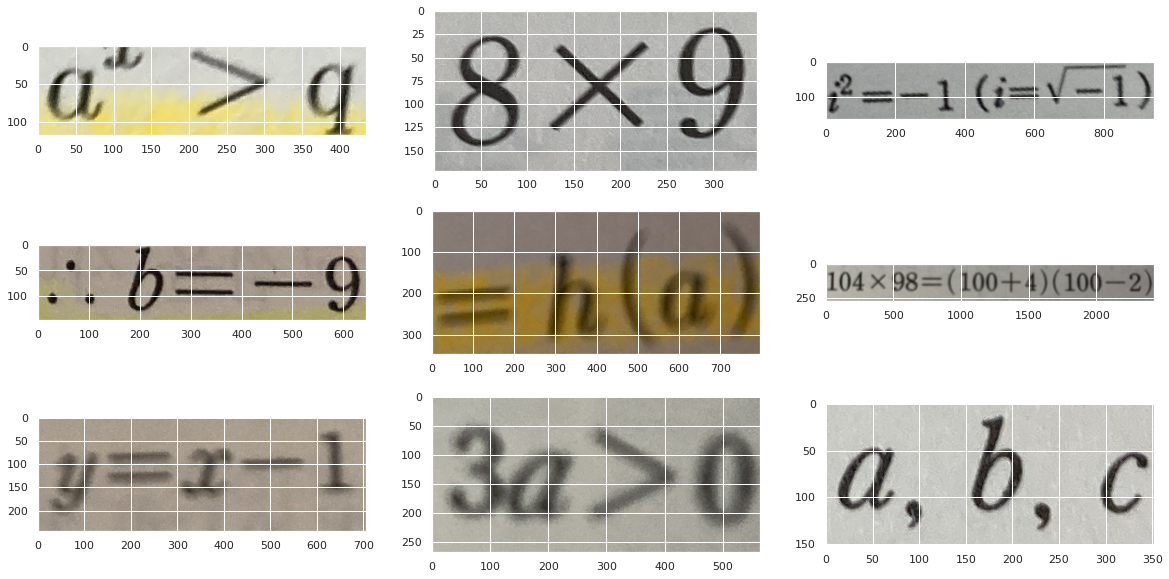

In [193]:
D = df[(df['level'] == 2) & (df['source'] == '0')]
print(len(D))
show_image(D, 20, 10)

11242


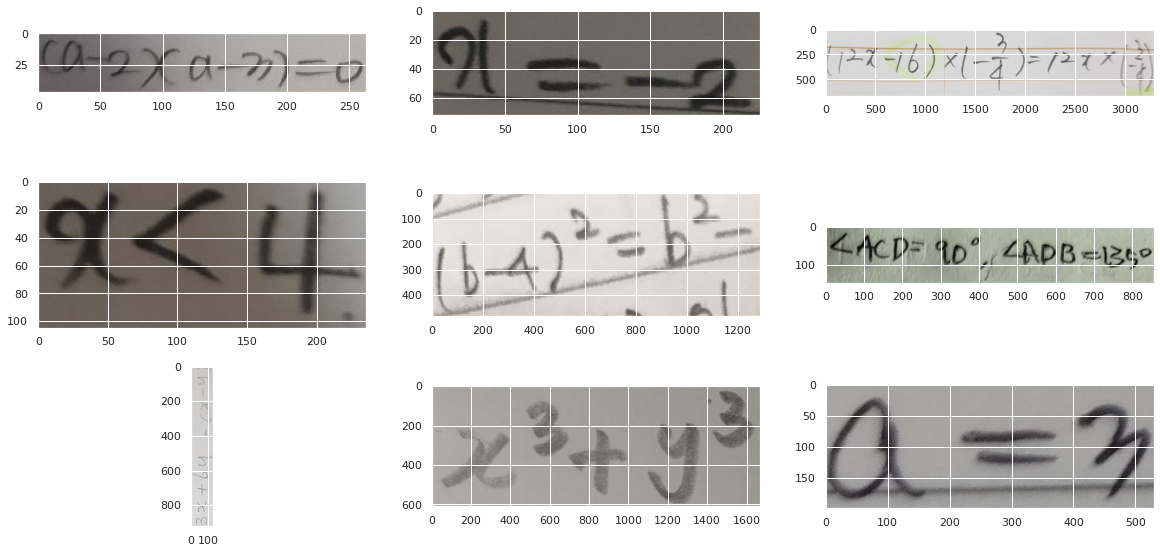

In [194]:
D = df[(df['level'] == 2) & (df['source'] == '1')]
print(len(D))
show_image(D, 20, 10)

#### Level 3

9236


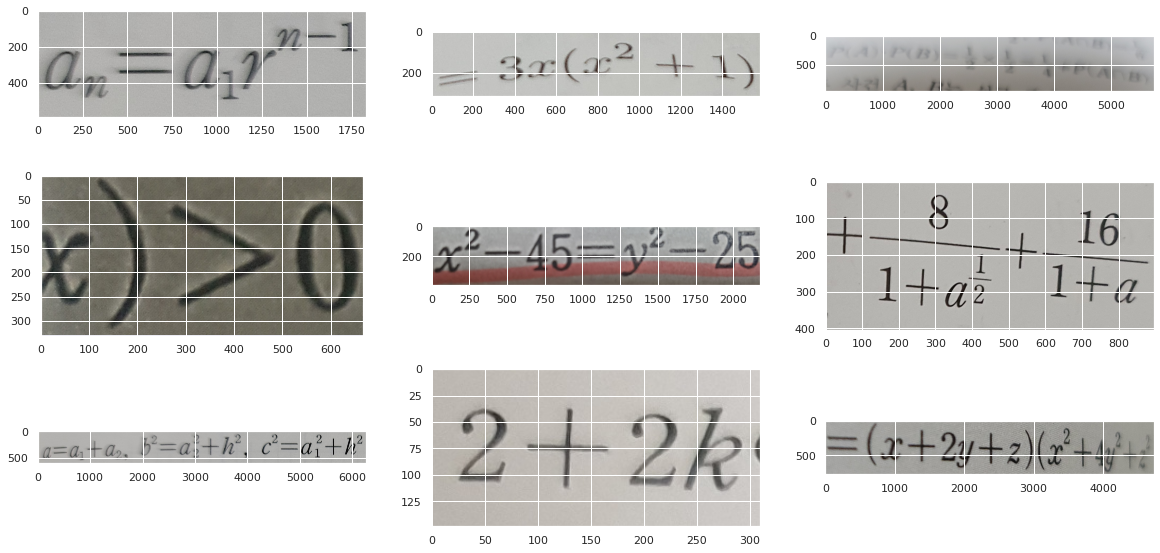

In [195]:
D = df[(df['level'] == 3) & (df['source'] == '0')]
print(len(D))
show_image(D, 20, 10)

24548


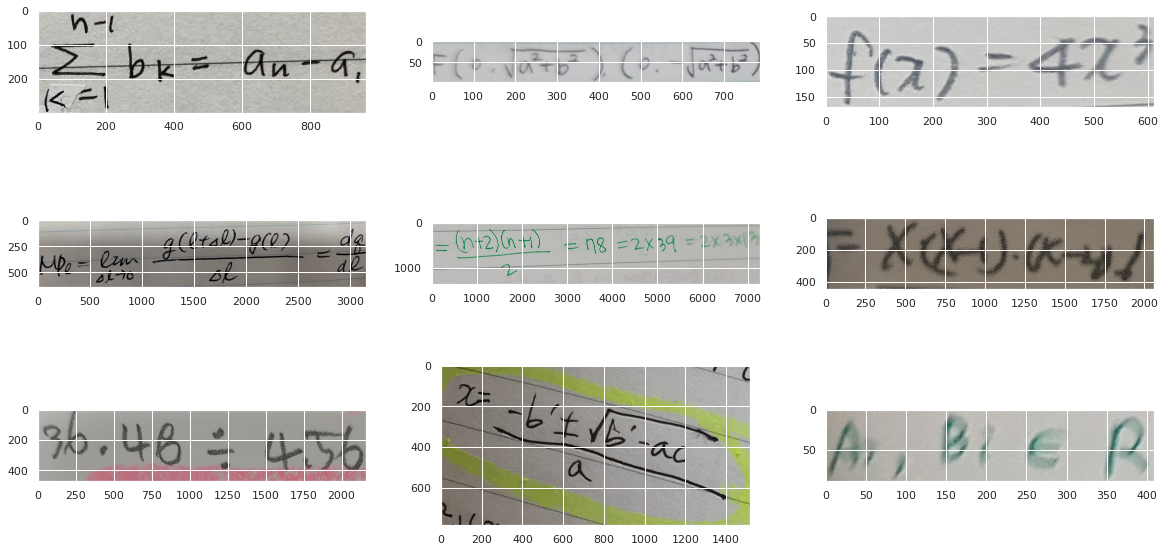

In [200]:
D = df[(df['level'] == 3) & (df['source'] == '1')]
print(len(D))
show_image(D, 20, 10)

#### Level 4

4156


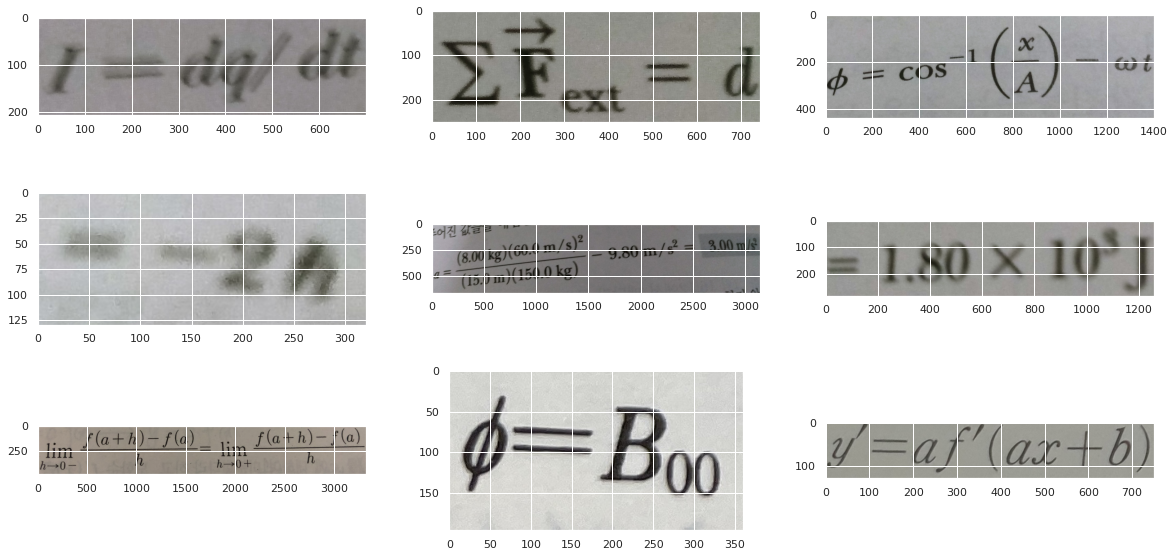

In [198]:
D = df[(df['level'] == 4) & (df['source'] == '0')]
print(len(D))
show_image(D, 20, 10)

4457


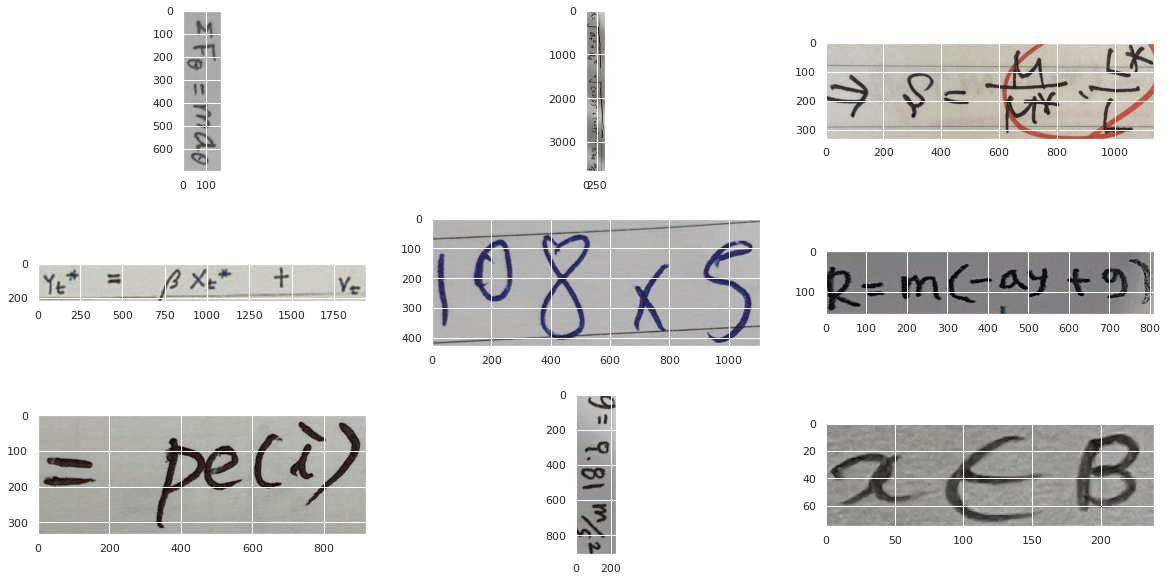

In [202]:
D = df[(df['level'] == 4) & (df['source'] == '1')]
print(len(D))
show_image(D, 20, 10)

#### Level 5

572


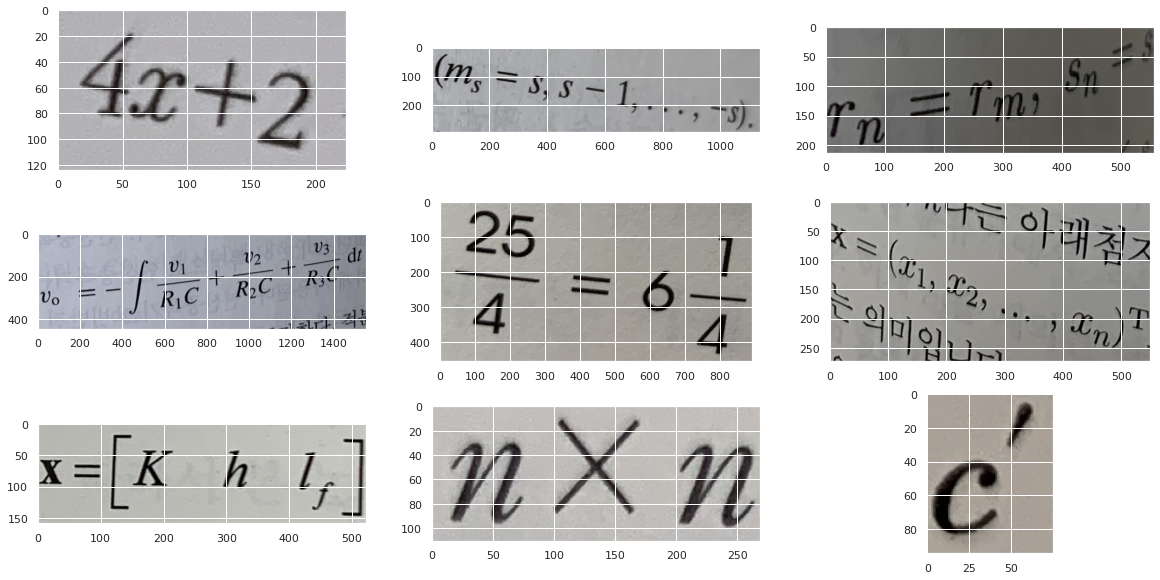

In [203]:
D = df[(df['level'] == 5) & (df['source'] == '0')]
print(len(D))
show_image(D, 20, 10)

In [206]:
D = df[(df['level'] == 5)]
print(len(D))

572


- level은 잘 모르겠고 source에 대한 분포가 train/valid나눌 때 영향 미칠 수 있을 것 같다.
- sequence의 길이가 영향 미쳐서 level이 중요할 수 있을 것 같기도? 

## Token Distribution

In [33]:
def creat_count_df(df, field, index, top_token):
    count = df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df[:top_token]

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(18, 6))
    if random_sample:
        df = df.sample(n=50, random_state = 1)
    ax.bar(df[field], df[field + '_count'], color = color, align = 'center', alpha = 0.5)
    ax.set_xticklabels(df[field], rotation=rotation, fontsize = 13)
    ax.set_xlabel(xlabel, fontsize = 13)
    ax.set_ylabel(ylabel, fontsize = 13)
    ax.set_title(title, fontsize = 20)
    plt.show()

In [34]:
token_df = pd.DataFrame(all_latex_list, columns = ['token'])
token_df['index'] = token_df.index

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


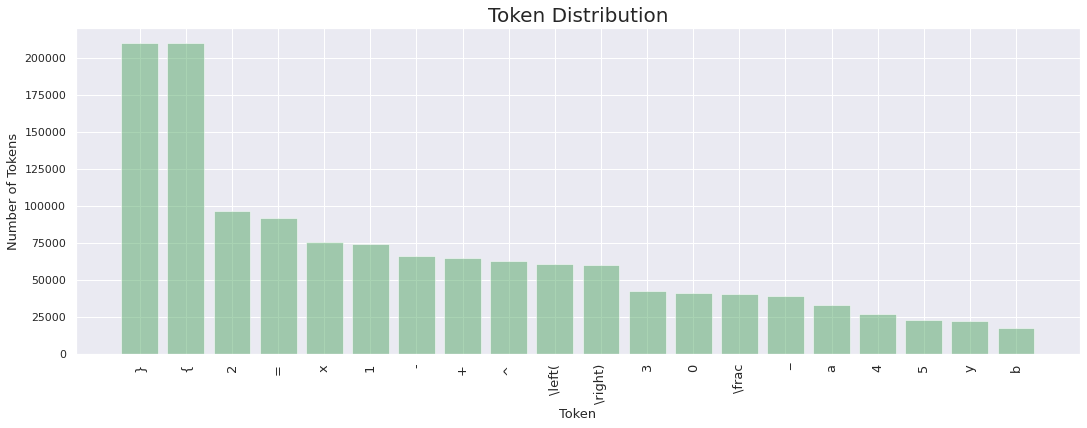

In [35]:
token_count_df = creat_count_df(df=token_df, field='token', index = 'index', top_token = 20)
plot_count_df(df=token_count_df, field='token', random_sample=False, color='g',rotation=90, xlabel='Token', ylabel='Number of Tokens', title='Token Distribution')

In [209]:
token_df

token    index
0             4        0
1        \times        1
2             7        2
3             =        3
4             2        4
...         ...      ...
1753688       !  1753688
1753689       =  1753689
1753690       1  1753690
1753691       2  1753691
1753692       0  1753692

[1753693 rows x 2 columns]